In [1]:
import numpy as np
import matplotlib.pyplot as plt
from scipy.ndimage import gaussian_filter1d, median_filter
from scipy.signal import savgol_filter
from scipy.interpolate import interp1d

## Define I(Q)

In [2]:
def S_hs(QD, phi):
    alpha = (1 + 2 * phi)**2 / (1 - phi)**4
    beta = -6 * phi * (1 + phi / 2)**2 / (1 - phi)**4
    gama = phi * alpha / 2
    
    G_hs = (alpha * (np.sin(QD) - QD * np.cos(QD)) / QD**2 +
            beta * (2 * QD * np.sin(QD) + (2 - QD**2) * np.cos(QD) - 2) / QD**3 +
            gama * (-QD**4 * np.cos(QD) + 4 * ((3 * QD**2 - 6) * np.cos(QD) +
            (QD**3 - 6 * QD) * np.sin(QD) + 6)) / QD**5)
    
    S = 1 / (24 * phi * G_hs/ QD + 1)
    
    return S

def P_hs(QD):
    P = (3*(np.sin(QD/2)-QD/2*np.cos(QD/2))/(QD/2)**3)**2
    P[QD==0] = 1    
    return P

In [3]:
q_grid = np.linspace(-12, 12, 128)
n_grid = len(q_grid)**2
qx, qy = np.meshgrid(q_grid, q_grid)
q_rad = np.sqrt(qx**2 + qy**2)
bin_edges = np.append(q_grid - (q_grid[1] - q_grid[0]) / 2, q_grid[-1] + (q_grid[1] - q_grid[0]) / 2)
d_bins = bin_edges[1] - bin_edges[0]
q = q_grid[q_grid > 0]

def f_I_q(n_sample, p_qxy, seed =1145141):
    np.random.seed(seed)
    n_pixel = n_sample/p_qxy.shape[0]  # number of samples per pixel

    # Flatten the arrays
    qx_flat = qx.flatten()
    qy_flat = qy.flatten()
    p_qxy_flat = p_qxy.flatten()

    # Normalize the probability density
    p_qxy_flat /= p_qxy_flat.sum()

    # Randomly choose indices based on the probability density
    indices = np.random.choice(len(qx_flat), size=n_sample, p=p_qxy_flat)

    # Get the sampled qx and qy values
    qx_samples = qx_flat[indices]
    qy_samples = qy_flat[indices]

    # evaluate the sampled point density in each grid

    I_q_grid, xedges, yedges = np.histogram2d(qx_samples, qy_samples, bins=[bin_edges, bin_edges])

    return I_q_grid

def f_I_q_rad(I_q_grid, q):
    # evaluate the radial averaged density
    q = q_grid[q_grid > 0]
    I_q = np.zeros_like(q)
    sum_q = np.zeros_like(q)
    n_pixels_q = np.zeros_like(q)
    I_pixels_q = []
    for i in range(len(q)):
        mask = (q_rad >= q[i] - (q[1] - q[0]) / 2) & (q_rad < q[i] + (q[1] - q[0]) / 2)
        I_pixels = I_q_grid[mask]
        sum_q[i] = I_pixels.sum()
        n_pixels_q[i] = mask.sum()
        I_q[i] = I_pixels.mean()
        
        I_pixels_q.append(I_pixels)
        
        
    return I_q, sum_q, n_pixels_q, I_pixels_q

In [4]:
I_inc = 5e-3
p_qxy = P_hs(q_rad*1.5)*S_hs(q_rad*1.5, 0.3) + I_inc
# p_qxy =p_debye(q_rad, Rg=1)+ I_inc
p_qxy[np.isfinite(p_qxy)==0] = 0
# p_qxy = np.ones_like(q_rad)
p_qxy = p_qxy/np.sum(p_qxy)

## GPR on different data quality

In [5]:
def f_loglin(x, x_c=1):
    return np.where(x < x_c, (x-x_c)/x_c+np.log(x_c), np.log(x))
def f_loglin_inv(y, y_c=0):
    return np.where(y < y_c, (1+y-y_c)*np.exp(y_c), np.exp(y))
def f_loglin_deriv(x, x_c=1):
    return np.where(x < x_c, 1/x_c, 1/x)

def f_mse(y, y_gt):
    return np.mean((y-y_gt)**2)/np.mean((y_gt)**2)

def desmear(Q,IQ,IQ_er,sigma_Q,n=3,sigmascale=1):
    I_ex = IQ
    I_ex_pos = I_ex[2*n:]
    I_ex_neg = I_ex[:-2*n]
    I_ex = I_ex[n:-n]
    sigma_Q_c = sigma_Q[n:-n]/sigmascale
    # sigma_Q_c = Q[n:-n]

    DQ = Q[n:] - Q[:-n]
    DQ_pos = DQ[n:]
    DQ_neg = DQ[:-n]

    I_ex2 = 2*(DQ_neg*I_ex_pos + DQ_pos*I_ex_neg - I_ex*(DQ_pos+DQ_neg))/(DQ_pos*DQ_neg*(DQ_pos+DQ_neg))
    I_des = I_ex - sigma_Q_c**2/2*I_ex2
    Q_des = Q[n:-n]

    # DI_ex = IQ_er
    # DI_ex[DI_ex==0] = np.min(DI_ex[DI_ex>0])
    # DI_ex_pos = DI_ex[2*n:]
    # DI_ex_neg = DI_ex[:-2*n]
    # DI_ex = DI_ex[n:-n]

    # DI_ex2_Sq = 4*((DQ_neg*DI_ex_pos)**2 + (DQ_pos*DI_ex_neg)**2 + ((DQ_neg+DQ_pos)*DI_ex)**2)/(DQ_pos*DQ_neg*(DQ_pos+DQ_neg))
    # DI_des = DI_ex*(1+sigma_Q_c**4/4*DI_ex2_Sq/DI_ex**2)
    
    return I_des

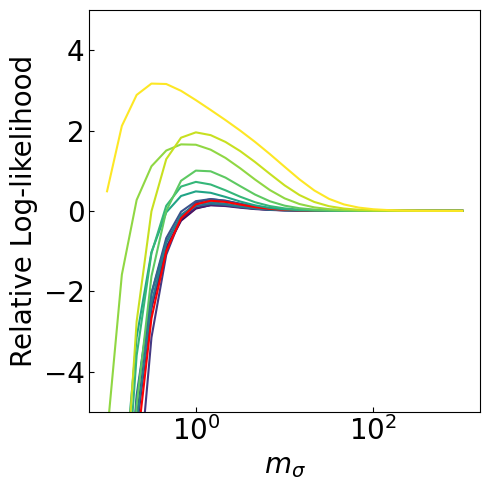

In [278]:
n_trial = 1
filter_size = 0.35
I_bg = I_inc
use_log_I = False
use_log_Q = False

# Transformations on Q and I(Q)
f_Q = lambda q: q
f_inv_Q = lambda fq: fq
if use_log_Q:
    f_Q = lambda q: np.log(q)
    f_inv_Q = lambda fq: np.exp(fq)


f_I = lambda I: I
f_inv_I = lambda fI: fI
# if use_log_I:
#     f_I = lambda I: np.log(I+I_bg)
#     f_inv_I = lambda fI: np.exp(fI)-I_bg
if use_log_I:
    f_I = lambda I: f_loglin(I, x_c=I_bg)
    f_inv_I = lambda fI: f_loglin_inv(fI, y_c=np.log(I_bg))

def get_viridis_color(value):
    cmap = plt.get_cmap('viridis')
    return cmap(value)

fig = plt.figure(figsize=(5, 5))

# n_sample_list = np.array([1000, 2000, 5000, 10000, 20000, 50000, 100000])
# n_sample_list = np.linspace(1000, 20000, 10)
n_sample_list = np.logspace(1, 7, 13)

list_L_gpr = []
list_L_exp = []
list_mse_gpr = []
list_mse_exp = []
for i_n, n_sample in enumerate(n_sample_list):
    
    ax = plt.subplot(1, 1, 1)

    n_sample = int(n_sample)
    color = get_viridis_color(i_n/(len(n_sample_list)-1))
    
    dq = q_grid[1] - q_grid[0]

    log_likelihood_gt_exp = 0
    log_likelihood_gt_gpr = 0
    mse_exp = 0
    mse_gpr = 0
    
    for i_trial in range(n_trial):
        seed_trial = np.random.randint(1e6)
        I_q_grid = f_I_q(n_sample, p_qxy, seed=None) ## count per pixel
        I_q, sum_q, n_pixels_q, I_pixels_q = f_I_q_rad(I_q_grid, q)
        I_q_th, _, _, _ = f_I_q_rad(p_qxy, q)
        I_q_th = I_q_th*n_sample
        
        #override I_q by given y_err
        y_err_pixel = np.sqrt(n_sample/np.sum(n_pixels_q)*(1/np.maximum(n_pixels_q,np.ones_like(q))+1e-3))
        np.random.seed(seed_trial)
        I_q = (I_q_th + np.random.normal(size = y.shape)*y_err_pixel)
        np.random.seed(None)
        
        I_q_gf = np.zeros_like(q)
        for i_iterate in range(1):
            I_q_gf_i = np.zeros_like(q)
            I_iterate = I_q - I_q_gf
            for i in range(len(q)):
                weight_list = np.exp(-((f_Q(q[i])-f_Q(q))/filter_size)**2/2)
                weight_list = weight_list/np.sum(weight_list)
                I_q_gf_i[i] = np.sum(I_iterate*weight_list)
            n_sm = 2
            I_q_gf_i[n_sm:-n_sm] = desmear(f_Q(q), I_q_gf_i, I_q_gf_i*0+1, np.ones_like(I_q_gf)*filter_size, n=n_sm, sigmascale=1)
            I_q_gf = I_q_gf + I_q_gf_i
        
        I_err_q = np.sqrt(1/n_pixels_q*[np.sum(I) for I in I_pixels_q]) # var: 1/n_pixels*sum(I)

        ## GPR
        sigma_list = np.logspace(-1, 3, 25)
        log_likelihood_list = []
        for sigma in sigma_list:
            lmbda = 0.35
            # sigma = 10

            ## define kernel function
            y_data = f_I(I_q/n_sample*n_grid)
            y_gt = f_I(I_q_th/n_sample*n_grid)
            y_bg = f_I(I_q_gf/n_sample*n_grid)
            y = y_data-y_bg

            # y_err = np.sqrt(n_sample/np.sum(n_pixels_q)*1/np.maximum(sum_q,np.ones_like(q)))
            y_err_pixel = np.sqrt(n_sample/np.sum(n_pixels_q)*(1/np.maximum(n_pixels_q,np.ones_like(q))+1e-3))/n_sample*n_grid
            y_err = y_err_pixel
            if use_log_I:
                y_err = y_err_pixel*f_loglin_deriv(I_q/n_sample*n_grid, x_c=I_bg)
                
            # np.random.seed(seed_trial)
            # y = (y_gt + np.random.normal(size = y.shape)*y_err) -y_bg
            # np.random.seed(None)
            
            # y_gf = np.zeros_like(y)
            # for i_iterate in range(2):
            #     y_gf_i = np.zeros_like(y)
            #     y_iterate = y_data - y_gf
            #     for i in range(len(q)):
            #         weight_list = np.exp(-((f_Q(q[i])-f_Q(q))/filter_size)**2/2)
            #         weight_list = weight_list/np.sum(weight_list)
            #         y_gf_i[i] = np.sum(y_iterate*weight_list)
            #     # n_sm = 2
            #     # y_gf_i[n_sm:-n_sm] = desmear(f_Q(q), f_I(y_gf_i), f_I(y_gf_i)*0+1, np.ones_like(y)*filter_size, n=n_sm, sigmascale=1)
            #     y_gf = y_gf + y_gf_i
            # y_bg = y_gf

            # scale by a factor to check whether error estimation is correct
            m_factor = 1
            y_bg = y_bg*m_factor
            y_gt = y_gt*m_factor
            y = y*m_factor #+ 1e-5*(np.max(y_gt)-np.min(y_gt))*np.random.normal(size = y.shape)
            y_err = y_err*m_factor #+ 1e-5*(np.max(y_gt)-np.min(y_gt))
            y_data = y_data*m_factor
            sig_var = np.mean(y**2)

            q_x = q
            q_s = q

            def f_K_rbf(q1, q2, lmbda, std_1=None, std_2=None):
                if std_1 is None:
                    std_1 = np.ones_like(q1)
                if std_2 is None:
                    std_2 = np.ones_like(q2)
                K = np.exp(-(q1[:, None] - q2[None, :])**2 / lmbda**2/2)*std_1[:, None]*std_2[None, :]
                return K
            
            f_y_err = lambda y_err: sigma**2*(y_err**2/np.sqrt(sig_var)**2)
            K_sigma = np.diag(f_y_err(y_err))
            # K_sigma = sigma**2*np.eye(len(q_x))
            K_xx = f_K_rbf(f_Q(q_x), f_Q(q_x), lmbda) + K_sigma #+ 0*np.eye(len(q_x))
            K_xs = f_K_rbf(f_Q(q_x), f_Q(q_s), lmbda)
            k_ss = f_K_rbf(f_Q(q_s), f_Q(q_s), lmbda)

            L = np.linalg.cholesky(K_xx)
            alpha = np.linalg.solve(L.T, np.linalg.solve(L, y))
            v = np.linalg.solve(L, K_xs)
            mu_s = K_xs.T @ alpha
            cov_s = k_ss - v.T @ v
            var_s = np.diag(cov_s)*np.sqrt(sig_var)**2
            std_s = np.sqrt(var_s)

            # evaluate the log likelihood
            def f_log_likelihood(y, y_err, mu_s, std_s, importance=np.ones_like(y), z_list = np.linspace(0, 0, 1)):
                ## average over the ovservation uncertainty   
                log_likelihood = 0   
                sum_weight = 0  
                for z in z_list:
                    weight_z = np.exp(-z**2/2)/np.sqrt(2*np.pi)
                    y_z = y + y_err*z
                    log_likelihood_z = -0.5 * np.sum(((y_z - mu_s)**2 / std_s**2 + np.log(2 * np.pi * std_s**2)))
                    log_likelihood += log_likelihood_z*weight_z
                    sum_weight += weight_z
                log_likelihood = log_likelihood/sum_weight
                return log_likelihood

            log_likelihood = f_log_likelihood(y, y_err, mu_s, std_s)  
            log_likelihood_list.append(log_likelihood)
            
        log_likelihood_list = np.array(log_likelihood_list)
        log_likelihood_list = (log_likelihood_list - log_likelihood_list[-1])/len(q_s)

        if n_sample == 10000:
            color = 'r'
        ax.plot(sigma_list, log_likelihood_list, '-', color=color, label=f'${n_sample:.0e}$'.replace('e+0', r'\times 10^'))
        ax.set_xscale('log')
        # ax.set_ylim([log_likelihood_list[-1]-(np.max(log_likelihood_list)-log_likelihood_list[-1])*1.5,log_likelihood_list[-1]+(np.max(log_likelihood_list)-log_likelihood_list[-1])*1.5])
        ax.set_ylim([-5, 5])
        # ax.set_xlim([3e-1, 3e2])
        ax.tick_params(direction='in', labelsize=20)
        ax.set_xlabel(r'$m_\sigma$', fontsize=20)
        ax.set_ylabel(r'Relative Log-likelihood', fontsize=20)

        sigma_best = sigma_list[np.argmax(log_likelihood_list)]
        
        # ax.legend(frameon=False, fontsize=13, ncol=2)
        plt.tight_layout()

        # GPR with best sigma
        f_y_err = lambda y_err: sigma_best**2*(y_err**2/np.sqrt(sig_var)**2)
        K_sigma = np.diag(f_y_err(y_err))
        # K_sigma = sigma**2*np.eye(len(q_x))
        K_xx = f_K_rbf(f_Q(q_x), f_Q(q_x), lmbda) + K_sigma
        K_xs = f_K_rbf(f_Q(q_x), f_Q(q_s), lmbda)
        k_ss = f_K_rbf(f_Q(q_s), f_Q(q_s), lmbda)

        L = np.linalg.cholesky(K_xx)
        alpha = np.linalg.solve(L.T, np.linalg.solve(L, y))
        v = np.linalg.solve(L, K_xs)
        mu_s = K_xs.T @ alpha
        cov_s = k_ss - v.T @ v
        var_s = np.diag(cov_s)*np.sqrt(sig_var)**2
        std_s = np.sqrt(var_s)
        
        I_mean_GP = f_inv_I(mu_s + y_bg)
        I_std_GP = std_s
        if use_log_I:
            I_std_GP = std_s/f_loglin_deriv(I_q/n_sample*n_grid, x_c=I_bg)
        
        # likelihood of gt within the experimental prediction
        log_likelihood_gt_exp += f_log_likelihood(f_inv_I(y_gt), np.ones_like(y_gt)*(np.max(f_inv_I(y_gt))-np.min(f_inv_I(y_gt)))*1e-3, f_inv_I(y_data), y_err_pixel, z_list=np.linspace(-4, 4, 49))
        
        # likelihood of gt within the GPR prediction
        log_likelihood_gt_gpr += f_log_likelihood(f_inv_I(y_gt), np.ones_like(y_gt)*(np.max(f_inv_I(y_gt))-np.min(f_inv_I(y_gt)))*1e-3, I_mean_GP, I_std_GP, z_list=np.linspace(-4, 4, 49))
        
        # mean squared error of gt and experimental prediction
        # mse_exp += f_mse(y + y_bg, y_gt)
        mse_exp += f_mse(f_inv_I(y_data),f_inv_I(y_gt))
        
        # mean squared error of gt and GPR prediction
        # mse_gpr += f_mse(mu_s + y_bg, y_gt)
        mse_gpr += f_mse(I_mean_GP, f_inv_I(y_gt))
        
    list_L_exp.append(log_likelihood_gt_exp/len(q)/n_trial)
    list_L_gpr.append(log_likelihood_gt_gpr/len(q)/n_trial)
    list_mse_exp.append(mse_exp/n_trial)
    list_mse_gpr.append(mse_gpr/n_trial)

# convert the lists to numpy arrays
list_L_exp = np.array(list_L_exp)
list_L_gpr = np.array(list_L_gpr)
list_mse_exp = np.array(list_mse_exp)
list_mse_gpr = np.array(list_mse_gpr)

Text(0, 0.5, '$L$')

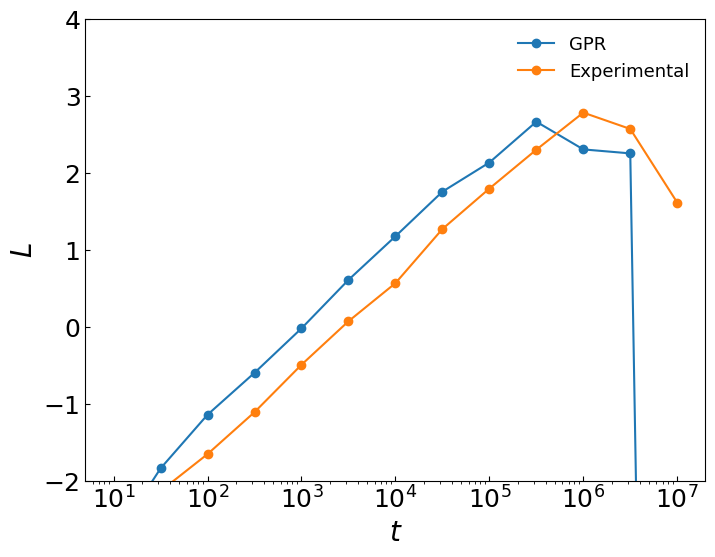

In [279]:
# plot the log likelihood as a function of n_sample
fig = plt.figure(figsize=(8, 6))
ax = plt.subplot(1, 1, 1)

ax.plot(n_sample_list, list_L_gpr, '-o', color='C0', label='GPR')
ax.plot(n_sample_list, list_L_exp, '-o', color='C1', label='Experimental')

ax.legend(frameon=False, fontsize=13)

ax.set_xticks(n_sample_list)
ax.set_xscale('log')
# ax.set_xlim([1e2, 1e4])
ax.set_ylim([-2, 4])
ax.tick_params(direction='in', labelsize=18)
ax.set_xlabel(r'$t$', fontsize=20)
ax.set_ylabel(r'$L$', fontsize=20)

Text(0, 0.5, '$\\mathrm{RMSE}$')

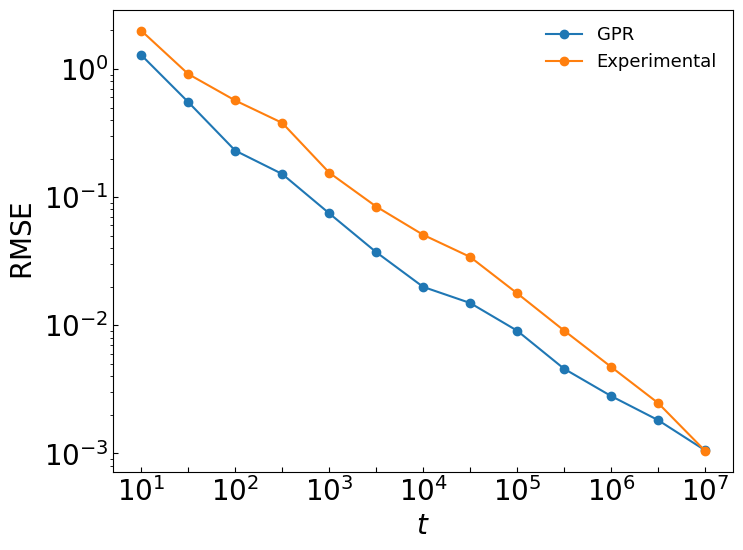

In [280]:
# plot the log likelihood as a function of n_sample
fig = plt.figure(figsize=(8, 6))
ax = plt.subplot(1, 1, 1)

ax.plot(n_sample_list, np.sqrt(list_mse_gpr), '-o', color='C0', label='GPR')
ax.plot(n_sample_list, np.sqrt(list_mse_exp), '-o', color='C1', label='Experimental')

ax.legend(frameon=False, fontsize=13)

ax.set_xscale('log')
ax.set_yscale('log')
ax.set_xticks(n_sample_list)
# ax.set_xlim([1e2, 1e4])
# ax.set_ylim([-2, 4])
ax.tick_params(direction='in', labelsize=20)
ax.set_xlabel(r'$t$', fontsize=20)
ax.set_ylabel(r'$\mathrm{RMSE}$', fontsize=20)

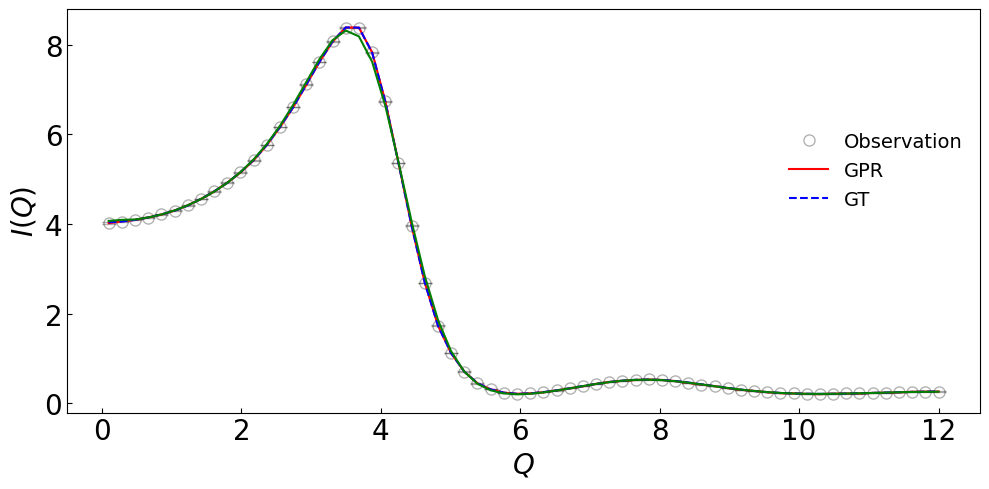

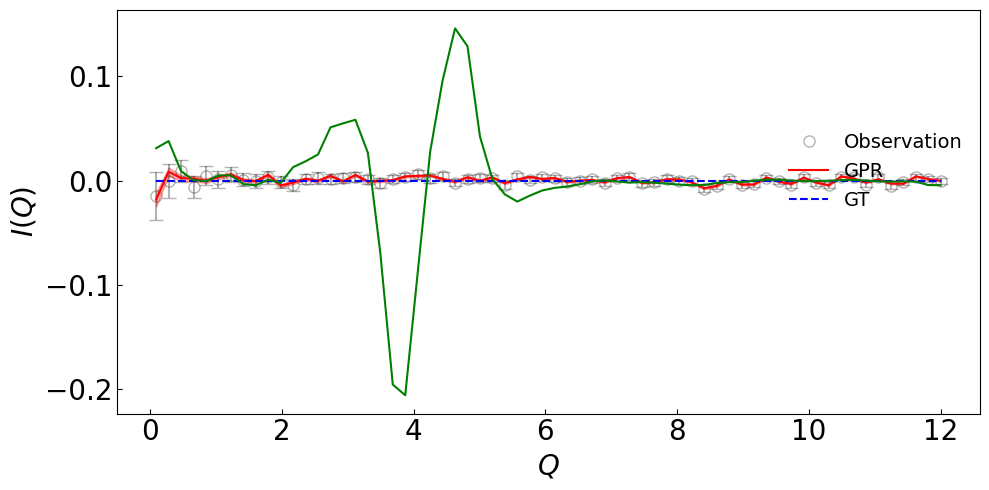

In [281]:
y_ref = y_gt

# plot the GPR result
fig = plt.figure(figsize=(10, 5))
ax = plt.subplot(1, 1, 1)

ax.plot(q_x, y + y_bg, 'ok', markersize=8, fillstyle='none', label='Observation', alpha=0.3) 
ax.errorbar(q_x, y + y_bg, yerr=y_err_pixel, fmt='none', ecolor='k', capsize=5, alpha=0.3)
ax.plot(q_s, mu_s + y_bg, '-r', label='GPR')
ax.fill_between(q_s, mu_s - std_s + y_bg, mu_s + std_s + y_bg, color='r', alpha=0.3)

ax.plot(q, y_gt , '--b', label='GT')

ax.plot(q_x, y_bg, '-g')

ax.set_xlabel(r'$Q$', fontsize=20)
ax.set_ylabel(r'$I(Q)$', fontsize=20)

ax.tick_params(direction='in', labelsize=20)
# ax.set_xscale('log')
# ax.set_yscale('log')
# ax.set_ylim([5e-2, 2e1])
# ax.set_ylim([0, 5])

ax.legend(frameon=False, fontsize=14, loc='right', bbox_to_anchor=(1, 0.6))
plt.tight_layout()

# plot the GPR result
fig = plt.figure(figsize=(10, 5))
ax = plt.subplot(1, 1, 1)

ax.plot(q_x, y + y_bg-y_ref, 'ok', markersize=8, fillstyle='none', label='Observation', alpha=0.3) 
ax.errorbar(q_x, y + y_bg-y_ref, yerr=y_err_pixel, fmt='none', ecolor='k', capsize=5, alpha=0.3)
ax.plot(q_s, mu_s + y_bg-y_ref, '-r', label='GPR')
ax.fill_between(q_s, mu_s - std_s + y_bg-y_ref, mu_s + std_s + y_bg-y_ref, color='r', alpha=0.3)

ax.plot(q, y_gt-y_ref , '--b', label='GT')

ax.plot(q_x, y_bg-y_ref, '-g')

ax.set_xlabel(r'$Q$', fontsize=20)
ax.set_ylabel(r'$I(Q)$', fontsize=20)

ax.tick_params(direction='in', labelsize=20)
# ax.set_xscale('log')
# ax.set_yscale('log')
# ax.set_ylim([5e-2, 2e1])
# ax.set_ylim([0, 5])

ax.legend(frameon=False, fontsize=14, loc='right', bbox_to_anchor=(1, 0.6))
plt.tight_layout()